# Project Topher Technical report
## Facebook pages reaction prediction app for online marketers
### Objectives
### Build a content recommendation application for facebook business page marketers

#### 1. Get data of facebook business pages contents using Facebook API
    - for the sake of simplicity, I picked grocery stores pages for this project   
    - I assume that grocery domain has less hidden meanings and is less dependent on other contexts
    comparing to other domains such as news agencies.
    - major grocery stores in the US: Whole Foods Market, Sprouts, Walmart, Safeway, Kroger

#### 2. data cleaning & eda
    - visualization
    - text cleaning & filtering(stop words)
    - ngrams

#### 3. Modeling & Classification
    - nlp: CountVectorizer, TF-IDF, n-gram 
    - classification(Logistic regression, AdaboostClassifier, Naive Bayes classifier, Keras, etc.)
    
#### 4. Create algorithms to recommend what to post based on the number/types of reactions

    - rank the posts based on 
        - the number of likes
        - type of emotions(positive vs. negative)
    - length of text
    - vector representation of text using Word2Vec
    - classify the posts based on types of contents(photo, link, text, offer)
    - readibility
  
#### 5. Scope
    - start with only one dataset(ex. Whole Foods Market)
    - add more data sets(competitors such as Sprouts, Walmart, Safeway, Kroger)
    - future work
     + expand scope of types of businesses
     + expand scope of analysis to other online marketing platforms

#### 6. Interface
    - create a web app using webapp service(ex. Flask, Django)
    - show actual web interface for facebook page managers

In [201]:
import pandas as pd
import numpy as np
from numpy import random
from scipy import stats
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from nltk.corpus import stopwords
import gensim

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

from sklearn.pipeline import Pipeline

import sys
sys.path.insert(0, './readability/')
sys.path.insert(0, './cleaning/')

from readability import Readability 
from text_cleaner import replace_with_regex

sns.set_style("darkgrid")

%matplotlib inline

### Exploratory Data Analysis

In [202]:
# read csv
wholefoods = pd.read_csv('./datasets/WholeFoods_facebook_statuses.csv')

# shape
print "wholefoods", wholefoods.shape

# look at the df
wholefoods.sample(5)

wholefoods (4845, 15)


,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
2588,24922591487_10151672719726488,What would you make with these ingredients?\n\...,Timeline Photos,photo,https://www.facebook.com/WholeFoods/photos/a.4...,2013-06-11 08:20:46,492,53,71,492,0,0,0,0,0
73,24922591487_10154938090251488,Have you entered yet?! 🙌 Who do you know that...,Share your fave clean beauty tip or product fo...,link,http://bit.ly/2n2RuAH,2017-03-24 17:54:22,218,54,17,202,9,0,0,4,3
3647,24922591487_194063900673064,Whole chickens are on sale for $1.29/lb at all...,Whole Story » Whole Chickens on Sale Today Onl...,link,http://blog.wholefoodsmarket.com/2011/11/whole...,2011-11-11 11:13:01,195,59,76,195,0,0,0,0,0
4258,24922591487_158488784184775,"Check out this video about Achatz Pies, one of...",Achatz Pies,link,http://www.youtube.com/watch?v=kQ5cS9gIrOk&fea...,2010-10-22 14:18:53,144,28,1,144,0,0,0,0,0
3375,24922591487_10150764748091488,"Between now and December 21, take advantage of...",NaN,status,NaN,2012-04-01 14:00:14,192,39,71,192,0,0,0,0,0


In [203]:
wholefoods.status_type.value_counts()

photo     2251
link      1515
video      737
status     336
offer        6
Name: status_type, dtype: int64

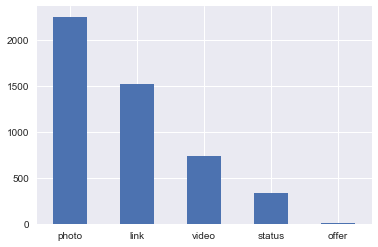

In [204]:
# see the distribution of data according to status_type category
wholefoods.status_type.value_counts().plot(kind="bar", rot=0)

             num_reactions
status_type               
link            261.923432
offer           588.500000
photo           796.514438
status          470.419643
video           393.883311


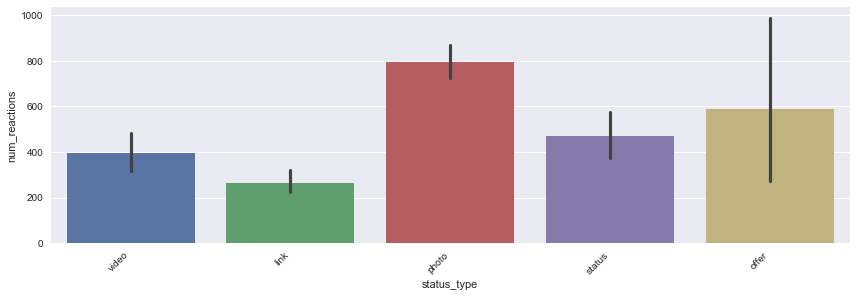

In [205]:
# num_reactions(mean) grouped by status_type
# maybe I could categorize data into status_type

print(wholefoods.groupby('status_type')[['num_reactions']].mean())
sns.factorplot(x='status_type', y='num_reactions',
               data=wholefoods, kind='bar', aspect=3).set_xticklabels(rotation=45, horizontalalignment='right')

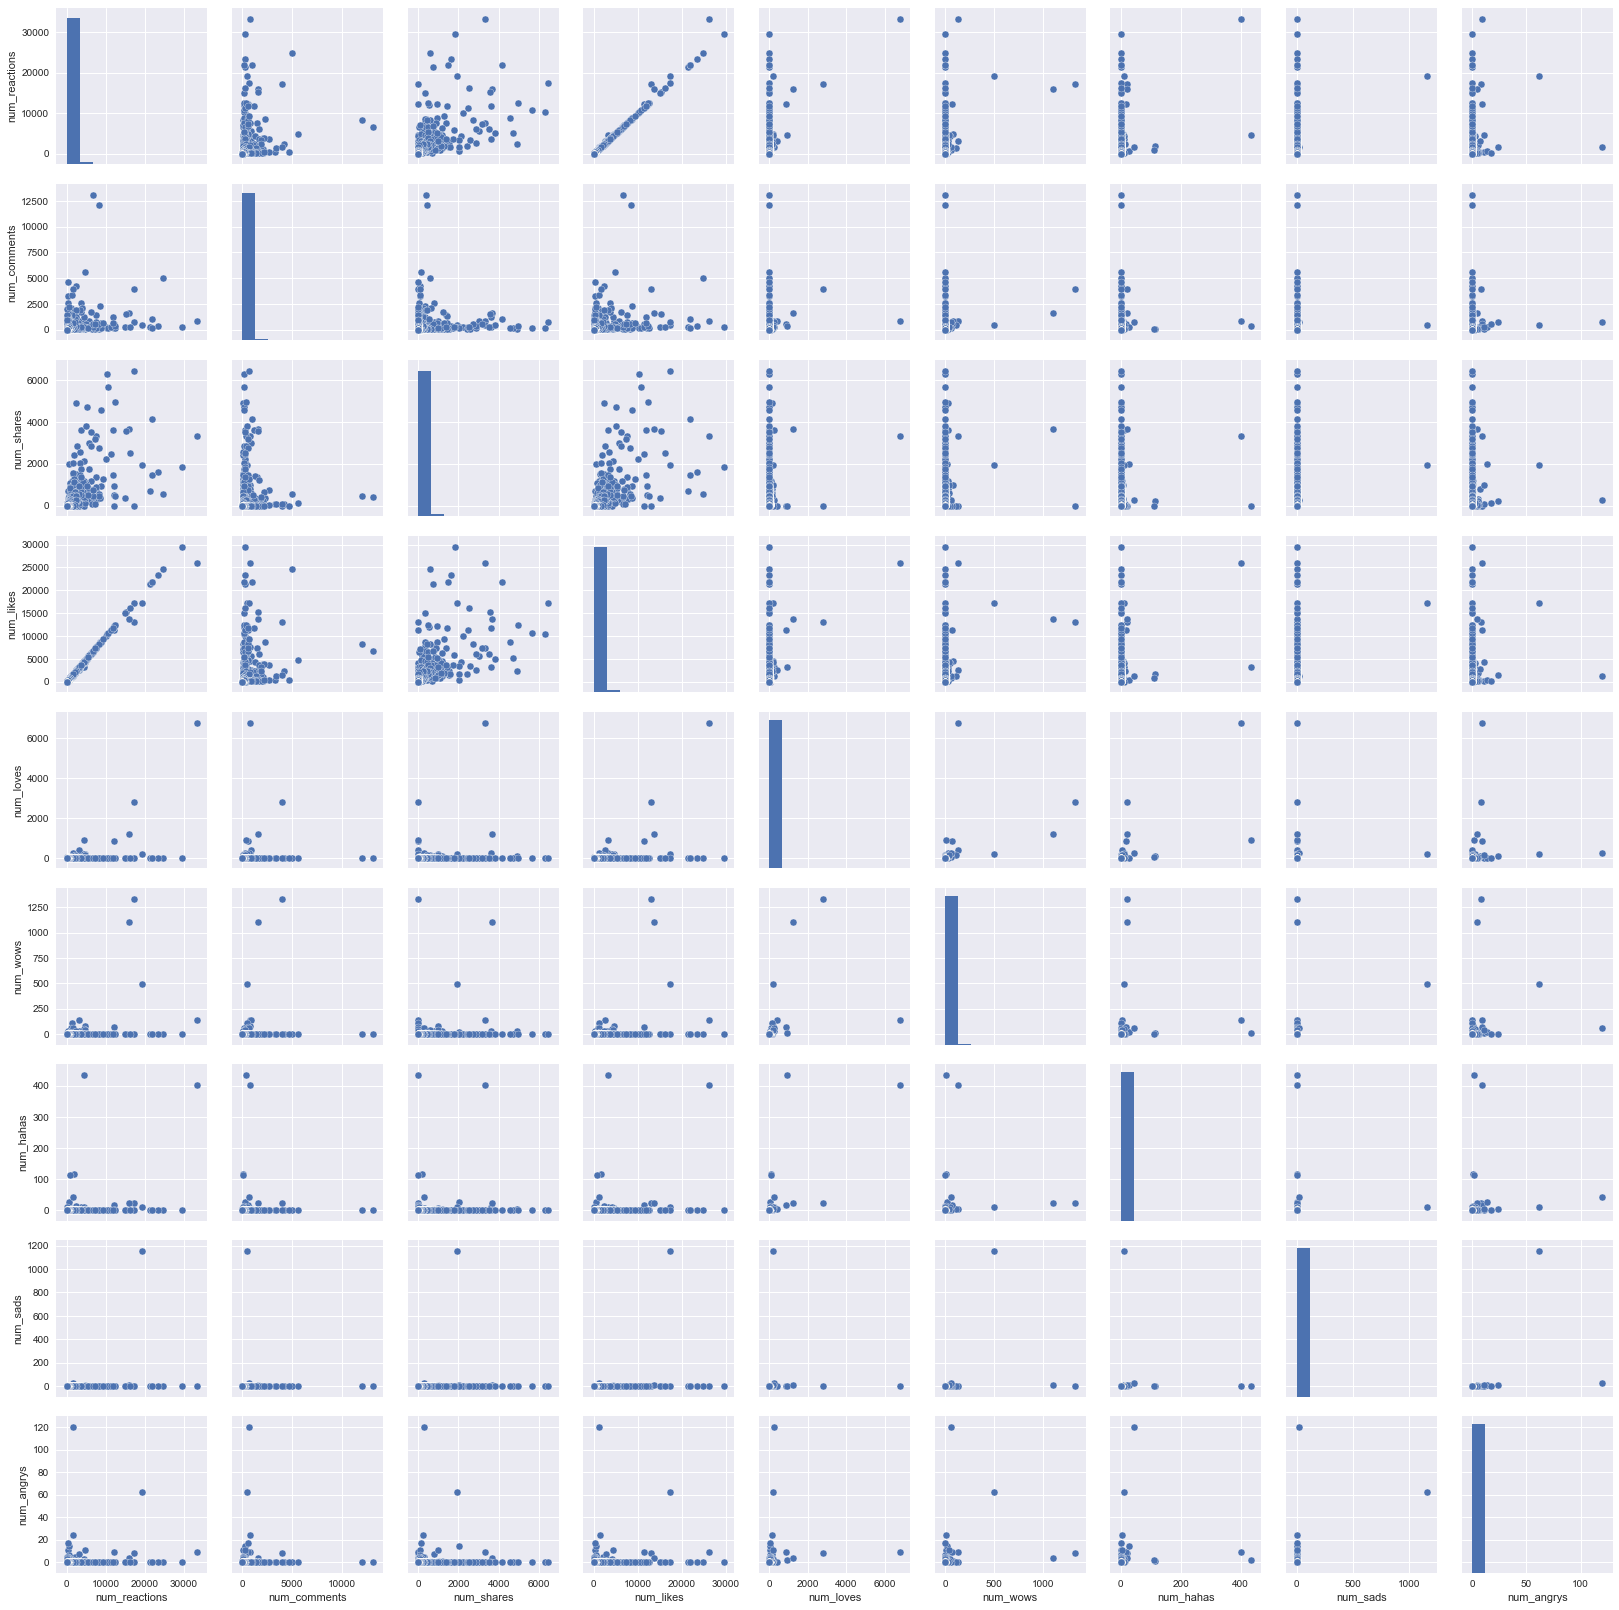

In [206]:
# I can see positive correlations among num_reactions, num_shares, num_likes
sns.pairplot(wholefoods)

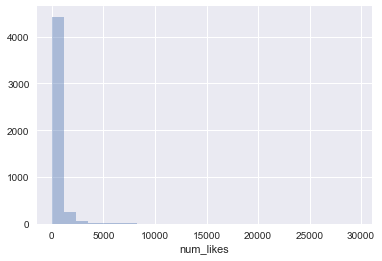

In [207]:
# distribution of num_likes
# seems like there are some huge outliers
sns.distplot(wholefoods.num_likes, kde=False, bins=25)

In [208]:
# set the name of column of emotions I'll analyze
emotion_type = "num_likes"

In [209]:
# see the number at 99 percentile 
percentage = 99
print stats.scoreatpercentile(wholefoods.num_likes, per=percentage)
outlier_cut_off = stats.scoreatpercentile(wholefoods.num_likes, per=percentage)

6249.56


In [210]:
# There are 49 outliers
print wholefoods[wholefoods.num_likes >= outlier_cut_off].shape

(49, 15)


In [211]:
# look into the rows which are considered as outliers
wholefoods[wholefoods.num_likes >= outlier_cut_off]

,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
16,24922591487_10155046057511488,💚 💚 💚,Whole Foods Has Gone Above and Beyond to Prote...,link,http://bit.ly/2qfCtfR,2017-04-26 14:01:24,33344,809,3335,26034,6761,135,403,2,9
117,24922591487_10154818851481488,Get mochi bar details from your local store!,Foodbeast,video,https://www.facebook.com/foodbeast/videos/1015...,2017-02-13 15:44:10,17242,3975,1,13094,2779,1335,22,4,8
146,24922591487_10154761814571488,We're excited to be your #1 Grocery Store for ...,The Daily Meal,link,http://www.thedailymeal.com/cook/america-s-bes...,2017-01-24 11:54:37,12224,547,0,11285,844,67,17,2,9
339,24922591487_10154462970606488,From pumpkin spice to apple pie... Refinery29 ...,The All-Time-Best Fall Products From Whole Foods,link,http://r29.co/2dRveFv,2016-10-20 10:34:10,16007,1596,3676,13676,1198,1102,22,5,4
496,24922591487_10153957101711488,This is what our bakery department would look ...,Timeline Photos,photo,https://www.facebook.com/WholeFoods/photos/a.4...,2016-04-15 17:18:10,19156,491,1951,17235,198,498,9,1154,62
546,24922591487_10153803405291488,Parmigiano Reggiano continues its reign as the...,Behind the Scenes: Parmigiano Reggiano,video,https://www.facebook.com/WholeFoods/videos/101...,2016-02-19 13:42:03,7479,405,3312,7479,0,0,0,0,0
570,24922591487_10153771290656488,"Delish cheesy goodness without the dairy, it's...",Kite Hill Behind the Scenes,video,https://www.facebook.com/WholeFoods/videos/101...,2016-02-03 14:23:10,11825,1194,3610,11825,0,0,0,0,0
621,24922591487_10153728357451488,Everyone's favorite sparkling water is on sale...,La Croix Sparkling Water,video,https://www.facebook.com/WholeFoods/videos/101...,2016-01-12 21:30:00,7451,1450,1365,7451,0,0,0,0,0
644,24922591487_10153714390126488,Finally! A vegan cheese made using traditional...,Kite Hill Nut-Milk Fresh Cheeses,video,https://www.facebook.com/WholeFoods/videos/101...,2016-01-05 14:46:59,15240,1522,3551,15240,0,0,0,0,0
776,24922591487_10153584019521488,Driscoll's Organic Raspberries are only $2.99/...,Timeline Photos,photo,https://www.facebook.com/WholeFoods/photos/a.4...,2015-10-28 06:00:01,6505,261,331,6505,0,0,0,0,0


In [212]:
wholefoods[wholefoods.num_likes >= outlier_cut_off]['status_type'].value_counts()

photo     38
video      5
link       3
status     3
Name: status_type, dtype: int64

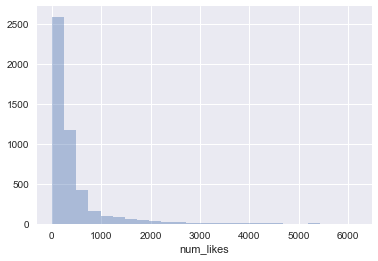

In [213]:
# see the distribution of data without outliers
wf_df = wholefoods[wholefoods['num_likes'] <= outlier_cut_off]
sns.distplot(wf_df.num_likes, kde=False, bins=25)

/Users/seoyeonchang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


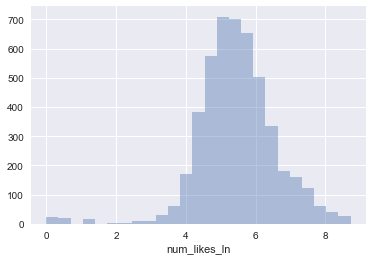

In [214]:
# natural log of number of reactions looks more normally distributed
wf_df['num_likes_ln'] = np.log(wf_df.num_reactions+1)
sns.distplot(wf_df.num_likes_ln, kde=False, bins=25)

In [215]:
# I'll filter out posts with a very small number of likes
# and this will make my data more normally distributed
# I'll remove these 60 posts with least number of likes
wf_df[wf_df['num_likes_ln'] <= 2].shape

(60, 16)

In [216]:
wf_df[wf_df['num_likes_ln'] <= 2]

,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,num_likes_ln
3618,24922591487_10150470949171488,Hypothetical scenario: You can choose ONLY 1 T...,NaN,status,NaN,2011-11-22 11:25:19,0,0,0,0,0,0,0,0,0,0.000000
3945,24922591487_10150235705036488,What are you most excited to do this weekend?,NaN,status,NaN,2011-04-29 16:06:09,0,2,0,0,0,0,0,0,0,0.000000
3967,24922591487_10150221940526488,Do you want our apps available on Android?,NaN,status,NaN,2011-04-14 10:32:47,0,0,0,0,0,0,0,0,0,0.000000
3969,24922591487_10150221460266488,What do you rely on as your main source for news?,NaN,status,NaN,2011-04-13 19:17:08,0,0,0,0,0,0,0,0,0,0.000000
3977,24922591487_10150215970561488,"When the end of your workday draws near, what ...",NaN,status,NaN,2011-04-07 15:54:52,0,0,0,0,0,0,0,0,0,0.000000
3986,24922591487_10150209667576488,Which new recipes would you like us to develop...,NaN,status,NaN,2011-04-01 12:55:11,0,0,0,0,0,0,0,0,0,0.000000
4283,24922591487_479755881487,What do you think about GMOs?,NaN,status,NaN,2010-10-01 15:46:28,0,0,0,0,0,0,0,0,0,0.000000
4664,24922591487_175153490707,Wonder what Jane Goodall & drinking Allegro Ta...,Dr. Jane Goodall,link,https://www.facebook.com/janegoodall/,2009-10-08 09:47:23,6,1,0,6,0,0,0,0,0,1.945910
4790,24922591487_60115481855,is getting hungry looking through the pictures...,NaN,status,NaN,2009-03-11 15:32:12,6,4,0,6,0,0,0,0,0,1.945910
4791,24922591487_68710608383,is curious if you've entered the Green Prom vi...,NaN,status,NaN,2009-03-10 15:11:30,1,12,0,1,0,0,0,0,0,0.693147


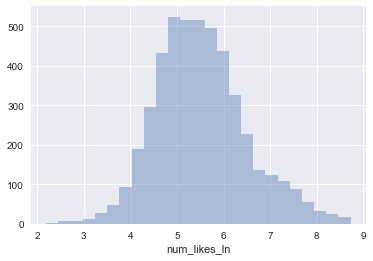

In [217]:
# looks better 
wf_ndf = wf_df[wf_df['num_likes_ln'] >= 2]
sns.distplot(wf_ndf.num_likes_ln, kde=False, bins=25)

In [218]:
wf_ndf.shape

(4736, 16)

In [219]:
wf_ndf.head(20)

,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,num_likes_ln
0,24922591487_10155067278746488,"Easy prep, endless possibilities! Stock up on ...",NaN,video,https://www.facebook.com/WholeFoods/videos/101...,2017-05-03 15:55:55,169,15,10,158,11,0,0,0,0,5.135798
1,24922591487_10155067078096488,#TeamCauliflower or #TeamKale?,Cauliflower Is the New Kale,link,https://bloom.bg/2p6Aiu4,2017-05-03 14:24:57,489,111,65,445,26,3,14,0,1,6.194405
2,24922591487_10155064019296488,Meet the newest products you can't live without.,What's New? 12 Reasons to Shop with Us This Month,link,http://bit.ly/2ptgAwe,2017-05-02 13:33:36,265,24,22,253,11,1,0,0,0,5.583496
3,24922591487_10155061626956488,"It's just like tuna salad, only it's #vegan! G...",NaN,video,https://www.facebook.com/WholeFoods/videos/101...,2017-05-01 17:35:06,551,70,263,514,30,2,2,2,1,6.313548
4,24922591487_10155060790421488,Say hello to May! 🌼,3 Fresh Spring Party Ideas from the Pros,link,http://bit.ly/2oYPzxh,2017-05-01 13:27:03,118,7,15,114,3,1,0,0,0,4.779123
5,24922591487_10155057844411488,"It's #mealprep time! Make this tonight, enjoy ...",NaN,video,https://www.facebook.com/WholeFoods/videos/101...,2017-04-30 15:51:08,269,25,54,255,8,5,0,1,0,5.598422
6,24922591487_10155057198476488,3 ways to use this limited-edition Tequila Lim...,"Rotisserie Chicken: Classic Dinner, New Flavor...",link,http://bit.ly/2oMsx1e,2017-04-30 11:49:02,206,16,30,195,7,4,0,0,0,5.332719
7,24922591487_10155054017306488,Rise and shine! Power up with this Blueberry M...,NaN,video,https://www.facebook.com/WholeFoods/videos/101...,2017-04-29 09:05:59,476,22,240,454,22,0,0,0,0,6.167516
8,24922591487_10155052338056488,Cheers to the weekend! Stock up on Organic Min...,NaN,video,https://www.facebook.com/WholeFoods/videos/101...,2017-04-28 16:50:58,1917,103,584,1789,122,5,1,0,0,7.559038
9,24922591487_10155052273436488,Stock up on this week's #DelishDeals through 5...,Photos from Whole Foods Market's post,photo,https://www.facebook.com/WholeFoods/photos/a.4...,2017-04-28 16:20:34,342,11,15,325,14,0,2,1,0,5.837730


In [220]:
# seems like there are some null values in status message, link_name and status_link 
wf_ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4736 entries, 0 to 4795
Data columns (total 16 columns):
status_id           4736 non-null object
status_message      4661 non-null object
link_name           4373 non-null object
status_type         4736 non-null object
status_link         4415 non-null object
status_published    4736 non-null object
num_reactions       4736 non-null int64
num_comments        4736 non-null int64
num_shares          4736 non-null int64
num_likes           4736 non-null int64
num_loves           4736 non-null int64
num_wows            4736 non-null int64
num_hahas           4736 non-null int64
num_sads            4736 non-null int64
num_angrys          4736 non-null int64
num_likes_ln        4736 non-null float64
dtypes: float64(1), int64(9), object(6)
memory usage: 629.0+ KB


In [221]:
# fill_na_and_reset_index 
def fill_na_and_reset_index(df):
    # fillna with ""(empty string)
    new_df = df.replace(np.nan,'', regex=True)
    # reset index
    new_df.index = range(new_df.shape[0])
    return new_df

wf_ndf = fill_na_and_reset_index(wf_ndf)

## Text cleaning

In [222]:
# For this project, I'll focus on text analysis trying to capture the relationship between texts and
# number of reactions
# Intuitively, the quality of pictures and videos has the biggest impact on capturing users sights at facebook 
# Most of people(58 out of 60 personals) I asked about this question answered that 
# the picture caught their sight first and next 'the link text' and the initial text message
# I'd like to exapand the scope of proejct into image & video analysis in the near future

In [223]:
# combine 'status messsage' and 'link name' column into 'text column' 
wf_ndf["text"] = wf_ndf["status_message"].map(str) + " " + wf_ndf["link_name"]

In [224]:
# no null value
wf_ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4736 entries, 0 to 4735
Data columns (total 17 columns):
status_id           4736 non-null object
status_message      4736 non-null object
link_name           4736 non-null object
status_type         4736 non-null object
status_link         4736 non-null object
status_published    4736 non-null object
num_reactions       4736 non-null int64
num_comments        4736 non-null int64
num_shares          4736 non-null int64
num_likes           4736 non-null int64
num_loves           4736 non-null int64
num_wows            4736 non-null int64
num_hahas           4736 non-null int64
num_sads            4736 non-null int64
num_angrys          4736 non-null int64
num_likes_ln        4736 non-null float64
text                4736 non-null object
dtypes: float64(1), int64(9), object(7)
memory usage: 666.0+ KB


In [225]:
# I'll get rid of unnecessary special characters, numbers and link names(ex: https://...)
wf_ndf['text'] = wf_ndf['text'].map(lambda x: replace_with_regex(x))

In [226]:
# looks clean
wf_ndf['text'].sample(100)

1700    In North America, over % of our packaged foods...
2321    What are you going to bake for your Thanksgivi...
3041    Opening night speaker series with Mark Bittman...
2071    Would you like a slice of Pineapple Upside-Dow...
3266    Show Mom how much you care by serving her some...
4018    Let's face it.....we ALL love to snack, right?...
2906    Tis' the season for money-saving strategies — ...
4349    via Fair Trade Certified: Fair Trade Certified...
4546    On a brighter note, what lights up your holida...
1410    Our very own Molly Siegler shares her Spiced A...
2069       Celebrating Passover? You should read this... 
2824    Have you ever seen green beans look this tasty...
1070    GRILLING TIP: Make sure you do it lots this su...
650     Wishing all of you a fantastic new year in ......
3601              ROASTED SPICED SWEET POTATOES & PEARS: 
1593    You're going to love this alternative to mashe...
2030    Think about the sizzle and the smoke...SKIRT S...
2547    These 

In [227]:
# look at the top 50 ngrams after tokenizing words
# need to do text cleaning
cvt      =  CountVectorizer(strip_accents='unicode', ngram_range=(2,4))
X_all    =  cvt.fit_transform(wf_ndf["text"])
columns  =  cvt.get_feature_names()

x_df     =  pd.DataFrame(X_all.toarray(), columns=columns)
tf_df    =  pd.DataFrame(x_df.sum(), columns=["freq"])
tf_df.sort_values("freq", ascending=False).head(50)

,freq
whole story,402
whole foods,362
timeline photos,346
do you,323
check out,309
foods market,300
whole foods market,300
in the,247
of the,235
how to,221


### Histogram of counts

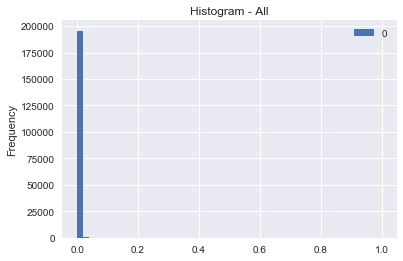

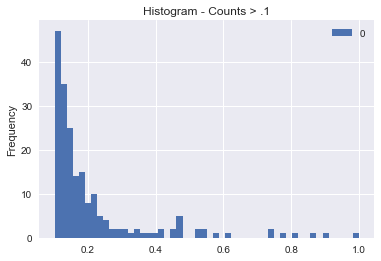

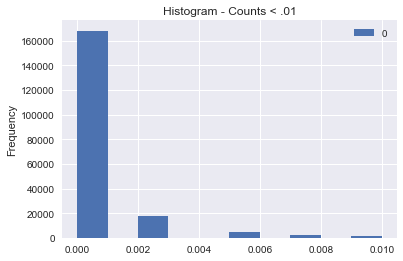

In [228]:
# look into the distribution of the most and the least frequent words

from sklearn.preprocessing import StandardScaler, minmax_scale

def hist_counts(X_all):

    hist_counts = pd.DataFrame(minmax_scale(x_df.sum()))
    hist_counts.plot(kind="hist", bins=50, title="Histogram - All")
    # There are a lot of really common tokens within 10% -- filter them out
    hist_counts[hist_counts[0] > .1].plot(kind="hist", bins=50, title="Histogram - Counts > .1") 
    # look at the range of extreme commons that seem to exist below .01
    hist_counts[hist_counts[0] < .01].plot(kind="hist", title="Histogram - Counts < .01") 
hist_counts(X_all)

### Try again with stopwords

In [229]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Can't see any difference from histogram without stopwords
# I need to look into the n-grams(most frequent + least frequent) and decide to include more stopwords
cvt      =  CountVectorizer(strip_accents='unicode', stop_words=stop, ngram_range=(2,4))
X_all    =  cvt.fit_transform(wf_ndf['text'])
# hist_counts(X_all)

### Most frequent ngrams

In [230]:
# I'll add more words to the stopwords list for many repeating ngrams 
# such as 'timeline photos', 'blog archive', 'wholefoodsmarket com', 'let us', 'blog wholefoodsmarket', 'whole story'
columns  =  cvt.get_feature_names()
x_df     =  pd.DataFrame(X_all.toarray(), columns=columns)
tf_df    =  pd.DataFrame(x_df.sum(), columns=["freq"])
tf_df.sort_values("freq", ascending=False).head(75)

,freq
whole story,402
whole foods,362
timeline photos,346
foods market,300
whole foods market,300
whole story blog,211
story blog,211
blog archive,191
whole story blog archive,190
story blog archive,190


In [231]:
tf_df.shape

(132005, 1)

### Least frequent ngrams

In [232]:
tf_df.sort_values("freq", ascending=False).tail(100)

,freq
gift card one day,1
gift card month supply,1
gift card month,1
gift card make sure,1
gift card make labor,1
gift card look,1
gift card livingsocial today,1
gift card livingsocial,1
gift card limit per,1
gift card today final,1


### Look at the ngrams in alphabetical order

In [233]:
#need to clean up least frequent words which appears only once throughout corpus
tf_df.head(500) 

,freq
abc com,1
abc com thetaste,1
abc com thetaste taste,1
abc details,1
abc new,2
abc new culinary,2
abc new culinary reality,2
abc watch,1
ability conduct,1
ability conduct surveillance,1


In [234]:
tf_df.tail(500)

,freq
yesterday day sale,1
yesterday day sale ricotta,1
yesterday essentially,1
yesterday essentially states,1
yesterday essentially states people,1
yesterday glen,1
yesterday glen mills,1
yesterday glen mills pa,1
yesterday many,1
yesterday many inspirational,1


### Include more stopwords

In [235]:
#include more stopwords after looking into the text data from many perspectives
stop = stopwords.words('english')
new_stop = ["timeline", "photos", "th", "wholefoodsmarket", "com", "http", "archive", "weve", "www",
           'whole', "market", "do", "you", "blog", "here", "timeline photos", "throughout", "us", 
            "know", "would", "users", "nan", "cover", "https", "facebook", "instagram", "user"]

stop.extend(new_stop)

## Modeling - Classification
### Try combination of text data vectorizer + classifier
#### 1) Text data vectorizer: Count Vectorizer, Tf-idf Vectorizer 
#### 2) Classifier: Logistic Regression, RandomForest Classifier, AdaboostClassifier, Multinomial Naive Bayes Classifier, Neural Networks(Keras)

In [236]:
# create target: split number of likes column into binary class(Above mean & Below mean)
def create_target(df):
    # mean of num_likes col
    mean = df[emotion_type].mean()
    # create a target column for classification dividing num_loves into 2 classes
    df['target'] = df[emotion_type].map(lambda x: 1 if x > mean else 0)
    return df

wf_ndf = create_target(wf_ndf)

#### CountVectorizer + Logistic Regression

In [237]:
# I won't use ngram_range for classification because ngrams increases the number of columns 
# more text columns, less accurate prediction
cvt      =  CountVectorizer(strip_accents='unicode', stop_words = stop)
X_all    =  cvt.fit_transform(wf_ndf["text"])
x_df     =  pd.DataFrame(X_all.toarray(), columns=cvt.get_feature_names())

In [238]:
# build predictors and target X, y
X = X_all
y = wf_ndf['target']

log_reg = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=8)

log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

# accuracy score: 0.734

0.73469387755102045

#### TfidfVectorizer + Logistic Regression

In [239]:
# Tfidf Vectorizer + Logistic Regression 
tvt =  TfidfVectorizer(strip_accents='unicode', stop_words = stop)
X_all=  tvt.fit_transform(wf_ndf["text"])
x_df =  pd.DataFrame(X_all.toarray(), columns=tvt.get_feature_names())

# build predictors and target X, y
X = X_all
y = wf_ndf['target']

log_reg = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=8)

log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

# accuracy score: 0.747 

0.74736101337086558

In [240]:
y_train.value_counts()

0    2463
1     852
Name: target, dtype: int64

In [241]:
y_test.value_counts()

0    1055
1     366
Name: target, dtype: int64

In [242]:
# I'll use Tf-idf vectorizer from now on. This is not only because I've got the better accuracy score
# with tfidf vectorizer but because tfidf vectorizer gives more weights frequent and important words 
# when creating sparse text matrix, which makes sense in this project

#### TfidfVectorizer + RandomForestClassifier

In [243]:
#accuracy score: 0.736
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(verbose=1)
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


0.73750879662209712

#### AdaBoostClassifier with decision tree classifier

In [244]:
# accuracy score: 0.724
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
dc = DecisionTreeClassifier(random_state=11, max_features = "auto", class_weight = "balanced", max_depth = 18)
estimator = AdaBoostClassifier(base_estimator = dc, n_estimators=120, learning_rate=.5)
estimator.fit(X_train, y_train)
estimator.score(X_test, y_test) 

0.72484166080225199

#### Multinomial Naive Bayes Classifier

In [245]:
# default -> 3 cross validation
# accuracy score: 0.744
nb_clf=MultinomialNB()
nb_clf.fit(X_train, y_train)
nb_clf.score(X_test, y_test)

0.74454609429978891

#### Neural Network(Keras)

In [68]:
# try to fit my model with neural networks classification model
# import Keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils

def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

y_train_ohe = one_hot_encode_object_array(y_train)
y_test_ohe = one_hot_encode_object_array(y_test)

model = Sequential()
model.add(Dense(16, input_shape=(7619, )))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
model.fit(X_train.toarray(), y_train_ohe, epochs=50, batch_size=1, verbose=1)
loss, accuracy = model.evaluate(X_test.toarray(), y_test_ohe, verbose=1)
print("Accuracy = {:.2f}".format(accuracy))
# with basic keras classification model, accuracy = 0.71

Epoch 1/50
3315/3315 [==============================] - 11s - loss: 0.5590 - acc: 0.7385    
Epoch 2/50
3315/3315 [==============================] - 10s - loss: 0.4916 - acc: 0.7496    
Epoch 3/50
3315/3315 [==============================] - 10s - loss: 0.4079 - acc: 0.8115    
Epoch 4/50
3315/3315 [==============================] - 10s - loss: 0.3398 - acc: 0.8501    
Epoch 5/50
3315/3315 [==============================] - 10s - loss: 0.2884 - acc: 0.8781    
Epoch 6/50
3315/3315 [==============================] - 10s - loss: 0.2487 - acc: 0.8995    
Epoch 7/50
3315/3315 [==============================] - 10s - loss: 0.2166 - acc: 0.9119    
Epoch 8/50
3315/3315 [==============================] - 10s - loss: 0.1934 - acc: 0.9246    
Epoch 9/50
3315/3315 [==============================] - 10s - loss: 0.1724 - acc: 0.9327    
Epoch 10/50
3315/3315 [==============================] - 10s - loss: 0.1553 - acc: 0.9418    
Epoch 11/50
3315/3315 [==============================] - 10s - loss: 

In [ ]:
# so far, I got the best accuracy score with logistic regression(0.7473)
# try to optimize parameters and cross validate for logistic regression when I am done with feature engineering

### More Feature Engineering

I'll try 4 more features below and decide which one to choose for my predictors 
My ultimate goal is to increase the accruacy score but the feature should be related to input data for the final product

#### 1) Types of contents
#### 2) Length of text
#### 3) Text readibility
#### 4) Word2Vec

### 1) Types of contents

In [246]:
# create new columns 
wf_ndf = pd.get_dummies(data=wf_ndf, columns=['status_type'])

In [247]:
# create dummy variable for each type of contents
wf_dummies = wf_ndf[['status_type_link', 'status_type_offer', 'status_type_photo', 
                                      'status_type_status','status_type_video']]

In [248]:
# concatenate the original text sparse matrix and dummy variables
new_df = pd.concat([x_df, wf_dummies], axis=1)

In [249]:
new_df.head()

,abc,ability,able,abound,abrams,abs,absolute,absolutely,absorbs,abstract,...,zipcar,zombies,zone,zoodles,zucchini,status_type_link,status_type_offer,status_type_photo,status_type_status,status_type_video
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0


In [250]:
# Tfidf Vectorizer + LogisticRegression -> accuracy score: 0.772
X = new_df
y = wf_ndf['target']

model = LogisticRegression(verbose=1)
X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y, train_size=0.6, random_state=8)

model.fit(X_train, y_train)
model.score(X_test, y_test)

[LibLinear]

0.77203166226912934

In [251]:
# Naive Bayes 
nb_clf=MultinomialNB()
nb_clf.fit(X_train, y_train)
nb_clf.score(X_test, y_test)

0.74986807387862797

In [252]:
# Definitely types of contents feature increases the accuracy score
# Actually I was going to use this feature for my model after I got a good score
# However, I am not going to include this for my model because this project is focused on text analysis
# not on image or video analysis 
# The fact that you post up an image of a video does not shows the quality of that
# Therefore, for the consistency of my model, I'll keep this feature for the future work

### 2) Length of texts(status_message & link_name)

In [253]:
# create columns for each of text part
wf_ndf['len_status_message'] = wf_ndf['status_message'].map(lambda x: len(x))
wf_ndf['len_link_name'] = wf_ndf['link_name'].map(lambda x: len(x))

In [254]:
len_text = wf_ndf[['len_status_message', 'len_link_name']]

In [255]:
new_df_2 = pd.concat([x_df, len_text], axis=1)

In [256]:
# Tfidf Vectorizer + LogisticRegression -> accuracy score: 0.7529
# These features increase the accuracy score a little bit. I'll include these for my model
X = new_df_2
y = wf_ndf['target']

model = LogisticRegression(verbose=1)
X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y, train_size=0.7, random_state=8)

model.fit(X_train, y_train)
model.score(X_test, y_test)

[LibLinear]

0.75299085151301903

### 3) Text Readability

In [257]:
# refer one of functions that measure the readability of a given body of text 
# https://github.com/mmautner/readability/blob/master/readability.py

In [258]:
# take this sentence as an example and see how it works
text = "I am going to school"
rd = Readability(text)
print rd.SMOGIndex()
# 3.0 means Grade 4 and below can understand this sentence.

3.0


In [259]:
wf_ndf.head()

,status_id,status_message,link_name,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,...,num_likes_ln,text,target,status_type_link,status_type_offer,status_type_photo,status_type_status,status_type_video,len_status_message,len_link_name
0,24922591487_10155067278746488,"Easy prep, endless possibilities! Stock up on ...",,https://www.facebook.com/WholeFoods/videos/101...,2017-05-03 15:55:55,169,15,10,158,11,...,5.135798,"Easy prep, endless possibilities! Stock up on ...",0,0,0,0,0,1,146,0
1,24922591487_10155067078096488,#TeamCauliflower or #TeamKale?,Cauliflower Is the New Kale,https://bloom.bg/2p6Aiu4,2017-05-03 14:24:57,489,111,65,445,26,...,6.194405,TeamCauliflower or TeamKale? Cauliflower Is th...,1,1,0,0,0,0,30,27
2,24922591487_10155064019296488,Meet the newest products you can't live without.,What's New? 12 Reasons to Shop with Us This Month,http://bit.ly/2ptgAwe,2017-05-02 13:33:36,265,24,22,253,11,...,5.583496,Meet the newest products you can't live withou...,0,1,0,0,0,0,48,49
3,24922591487_10155061626956488,"It's just like tuna salad, only it's #vegan! G...",,https://www.facebook.com/WholeFoods/videos/101...,2017-05-01 17:35:06,551,70,263,514,30,...,6.313548,"It's just like tuna salad, only it's vegan! Ge...",1,0,0,0,0,1,92,0
4,24922591487_10155060790421488,Say hello to May! 🌼,3 Fresh Spring Party Ideas from the Pros,http://bit.ly/2oYPzxh,2017-05-01 13:27:03,118,7,15,114,3,...,4.779123,Say hello to May! 🌼 Fresh Spring Party Ideas...,0,1,0,0,0,0,22,40


In [260]:
import sys
sys.path.insert(0, './readability/')
sys.path.insert(0, './cleaning/')

from readability import Readability 

wf_ndf['readability_status_message'] = wf_ndf['status_message'].map(lambda x: Readability(x).SMOGIndex())
wf_ndf['readability_link_name'] = wf_ndf['link_name'].map(lambda x: Readability(x).SMOGIndex())

In [261]:
readability_status_message = wf_ndf['readability_status_message']
readability_link_name = wf_ndf['readability_link_name']

In [262]:
new_df_3 = pd.concat([new_df_2, readability_status_message, readability_link_name], axis=1)

In [263]:
# Tfidf Vectorizer + LogisticRegression
X = new_df_3
y = wf_ndf['target']

model = LogisticRegression(verbose=1)
X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y, train_size=0.7, random_state=8)

model.fit(X_train, y_train)
model.score(X_test, y_test)
#accuracy score: 0.76 -> I'll include this feature for my model as well

[LibLinear]

0.7670654468684025

In [ ]:
# For the next step, I aggregated all the source code for my program for other notebooks
# only for whole foods market dataset -> 'capstone_final_wholefoods_classification.ipynb'
# all five groceru stores -> 'capstone_final_5_grocery_stores_classification.ipynb'
# For capstone presentation slieds 
# -> https://docs.google.com/presentation/d/1k3GncIhqxXZry0RJO0jD54W3dHBb_0oKoMamfViFbeY/edit?usp=sharing